### Import Packages 

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# SkLearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Path Definition

In [2]:
tr_path = 'covid.train.csv'
tt_path = 'covid.test.csv'

### Set Random Seed for Reproducibility

In [3]:
myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Function for detecting the device can be used

In [4]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

### Function for plot the graph of the result

In [5]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

In [6]:
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

### Set Global Mean and STD

In [7]:
mean = None
std = None

### Torch Dataset definition with feature selection in

In [8]:
class COVID19Dataset(Dataset):
    # feature selection from K best & get the score which better than 0.7
    def feature_selection(self):
        def select_with_k_best(X_train, y_train, X_test):
            # configure to select all features
            fs = SelectKBest(score_func=mutual_info_regression, k='all')
            # learn relationship from training data
            fs.fit(X_train, y_train)

            return fs

        # load the dataset
        df = pd.read_csv(tr_path)
        X = df.iloc[:, 41:-1]
        y = df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        fs = select_with_k_best(X_train, y_train, X_test)
        # what are scores for the features
        ids = []
        for i in range(len(fs.scores_)):
            if fs.scores_[i] > 0.7:
                ids.append(40+i)
        
        print(ids)

        return ids
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train'):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        # ignore the 40 states features and select the features from KBest
        feats = self.feature_selection()

        if mode == 'test':
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feats]
            
            '''
            split the data from train and dev with 9:1 ratio
            choose the reminder 3 make distribution like the public data
            '''
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 3]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 3]
            
            data = data[indices]
            target = target[indices]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data) 
            self.target = torch.FloatTensor(target)

        global mean
        global std

        '''
        Calculate the first calling class data (train data)
        Save the Mean and STD in global
        And normalize after
        '''
        if mean is None:
            mean = self.data.mean(dim=0, keepdim=True)
            std = self.data.std(dim=0, keepdim=True)

        self.data = (self.data - mean) / std

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

### DataLoader

In [9]:
def prep_dataloader(path, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)
    return dataloader

### NN Model

In [10]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            # nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss()

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return torch.sqrt(self.criterion(pred, target)) # RMSE


### modelling function

In [11]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                    .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [12]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [13]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

### Config File Setting

In [14]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 15,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.000015,               # learning rate of SGD
        'momentum': 0.9,             # momentum for SGD
        'weight_decay': 0.000015
    },
    'early_stop': 100,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

### Load Data

In [15]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'])
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'])
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'])

[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]
Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 14)
[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 14)
[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


### model training

In [16]:
model = NeuralNet(tr_set.dataset.dim).to(device)

model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 17.0800)
Saving model (epoch =    2, loss = 16.9563)
Saving model (epoch =    3, loss = 16.8298)
Saving model (epoch =    4, loss = 16.7008)
Saving model (epoch =    5, loss = 16.5670)
Saving model (epoch =    6, loss = 16.4268)
Saving model (epoch =    7, loss = 16.2815)
Saving model (epoch =    8, loss = 16.1285)
Saving model (epoch =    9, loss = 15.9668)
Saving model (epoch =   10, loss = 15.7988)
Saving model (epoch =   11, loss = 15.6190)
Saving model (epoch =   12, loss = 15.4290)
Saving model (epoch =   13, loss = 15.2254)
Saving model (epoch =   14, loss = 15.0107)
Saving model (epoch =   15, loss = 14.7820)
Saving model (epoch =   16, loss = 14.5416)
Saving model (epoch =   17, loss = 14.2845)
Saving model (epoch =   18, loss = 14.0124)
Saving model (epoch =   19, loss = 13.7296)
Saving model (epoch =   20, loss = 13.4319)
Saving model (epoch =   21, loss = 13.1212)
Saving model (epoch =   22, loss = 12.8017)
Saving model (epoch =   23, loss

Saving model (epoch =  199, loss = 1.0109)
Saving model (epoch =  200, loss = 1.0085)
Saving model (epoch =  204, loss = 1.0071)
Saving model (epoch =  205, loss = 1.0046)
Saving model (epoch =  208, loss = 1.0027)
Saving model (epoch =  210, loss = 0.9995)
Saving model (epoch =  213, loss = 0.9966)
Saving model (epoch =  216, loss = 0.9936)
Saving model (epoch =  218, loss = 0.9913)
Saving model (epoch =  220, loss = 0.9909)
Saving model (epoch =  221, loss = 0.9896)
Saving model (epoch =  225, loss = 0.9876)
Saving model (epoch =  226, loss = 0.9863)
Saving model (epoch =  229, loss = 0.9831)
Saving model (epoch =  233, loss = 0.9796)
Saving model (epoch =  237, loss = 0.9777)
Saving model (epoch =  238, loss = 0.9775)
Saving model (epoch =  239, loss = 0.9762)
Saving model (epoch =  241, loss = 0.9746)
Saving model (epoch =  244, loss = 0.9736)
Saving model (epoch =  245, loss = 0.9709)
Saving model (epoch =  249, loss = 0.9683)
Saving model (epoch =  252, loss = 0.9672)
Saving mode

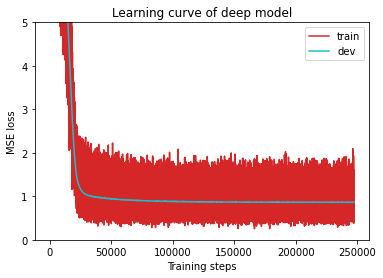

In [17]:
plot_learning_curve(model_loss_record, title='deep model')

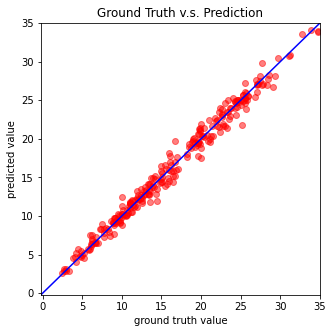

In [18]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [19]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [20]:
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


### REFERENCE

* TA's code
* [Feature Selection with KBest](https://www.kaggle.com/jepsds/feature-selection-using-selectkbest)